# Random Forest Classifier: Landslide vs Non-Landslide

Binary classification using slope raster data.

**Data:**
- 109 landslide rasters (label=1)
- 268 non-landslide rasters (label=0)
- Each raster: 5×5km at 10m resolution (~500×500 pixels)

In [1]:
import numpy as np
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## 1. Load All Rasters

In [2]:
raster_dir = Path("../Slope/Output/valid_rasters")

landslide_files = sorted(raster_dir.glob("landslide_*.tif"))
non_landslide_files = sorted(raster_dir.glob("no_landslide_*.tif"))

print(f"Landslide rasters: {len(landslide_files)}")
print(f"Non-landslide rasters: {len(non_landslide_files)}")
print(f"Total: {len(landslide_files) + len(non_landslide_files)}")

Landslide rasters: 109
Non-landslide rasters: 268
Total: 377


In [3]:
def load_raster(filepath):
    """Load raster and return flattened valid pixels."""
    with rasterio.open(filepath) as src:
        data = src.read(1)
    # Mask invalid values
    valid_mask = (data >= 0) & (data <= 90)
    return data, valid_mask

def extract_features_from_raster(data, valid_mask):
    """Extract statistical features from raster."""
    valid_data = data[valid_mask]
    if len(valid_data) == 0:
        return None
    
    return np.array([
        np.mean(valid_data),
        np.median(valid_data),
        np.std(valid_data),
        np.min(valid_data),
        np.max(valid_data),
        np.percentile(valid_data, 25),
        np.percentile(valid_data, 75),
        np.percentile(valid_data, 90),
        np.percentile(valid_data, 10),
        np.max(valid_data) - np.min(valid_data),
        np.std(valid_data) / np.mean(valid_data) if np.mean(valid_data) > 0 else 0,
    ])

FEATURE_NAMES = ['mean', 'median', 'std', 'min', 'max', 'p25', 'p75', 'p90', 'p10', 'range', 'cv']

In [4]:
# Load and extract features from all rasters
print("Loading landslide rasters...")
X_landslide = []
for f in landslide_files:
    data, mask = load_raster(f)
    features = extract_features_from_raster(data, mask)
    if features is not None:
        X_landslide.append(features)
X_landslide = np.array(X_landslide)
y_landslide = np.ones(len(X_landslide))

print("Loading non-landslide rasters...")
X_non_landslide = []
for f in non_landslide_files:
    data, mask = load_raster(f)
    features = extract_features_from_raster(data, mask)
    if features is not None:
        X_non_landslide.append(features)
X_non_landslide = np.array(X_non_landslide)
y_non_landslide = np.zeros(len(X_non_landslide))

print(f"\nLoaded: {len(X_landslide)} landslide, {len(X_non_landslide)} non-landslide")

Loading landslide rasters...
Loading non-landslide rasters...

Loaded: 109 landslide, 268 non-landslide


In [5]:
# Combine datasets
X = np.vstack([X_landslide, X_non_landslide])
y = np.concatenate([y_landslide, y_non_landslide])

print(f"Total samples: {len(X)}")
print(f"Features per sample: {X.shape[1]}")
print(f"Class distribution: {int(sum(y))} landslide, {int(len(y)-sum(y))} non-landslide")

Total samples: 377
Features per sample: 11
Class distribution: 109 landslide, 268 non-landslide


## 2. Visualize Feature Distributions

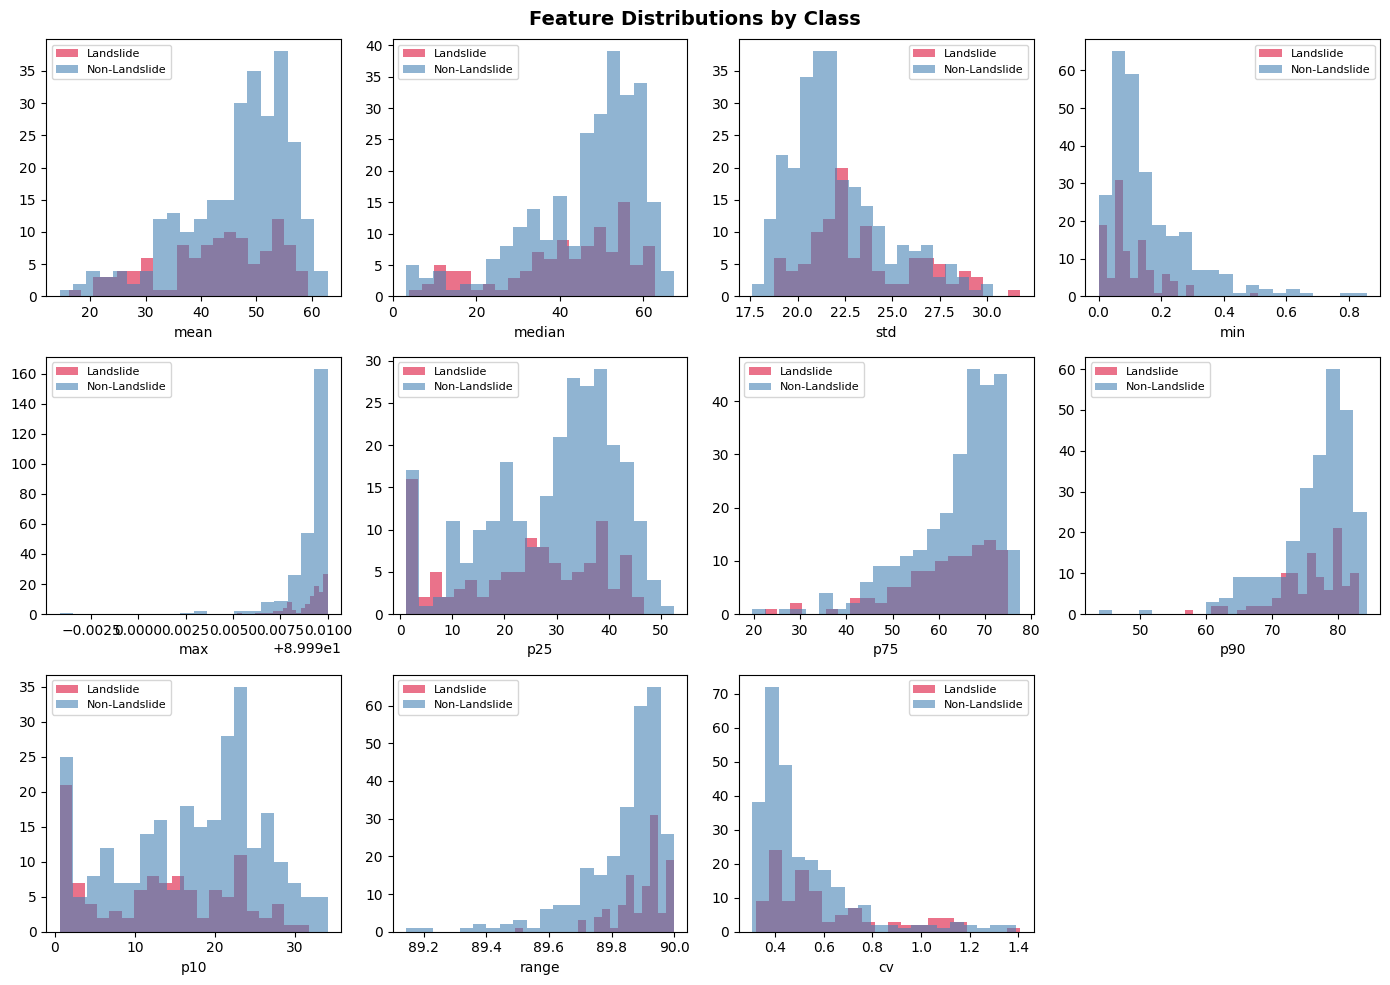

In [6]:
df = pd.DataFrame(X, columns=FEATURE_NAMES)
df['label'] = y
df['class'] = df['label'].map({1: 'Landslide', 0: 'Non-Landslide'})

fig, axes = plt.subplots(3, 4, figsize=(14, 10))
axes = axes.flatten()

for idx, feat in enumerate(FEATURE_NAMES):
    ax = axes[idx]
    for label, color in [(1, 'crimson'), (0, 'steelblue')]:
        data = df[df['label'] == label][feat]
        ax.hist(data, bins=20, alpha=0.6, color=color, 
                label='Landslide' if label==1 else 'Non-Landslide')
    ax.set_xlabel(feat)
    ax.legend(fontsize=8)

axes[-1].axis('off')
plt.suptitle('Feature Distributions by Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training: {len(X_train)} samples")
print(f"  - Landslide: {int(sum(y_train))}")
print(f"  - Non-landslide: {int(len(y_train)-sum(y_train))}")
print(f"\nTest: {len(X_test)} samples")
print(f"  - Landslide: {int(sum(y_test))}")
print(f"  - Non-landslide: {int(len(y_test)-sum(y_test))}")

Training: 301 samples
  - Landslide: 87
  - Non-landslide: 214

Test: 76 samples
  - Landslide: 22
  - Non-landslide: 54


## 4. Train Random Forest

In [8]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Model trained!")

Model trained!


In [9]:
# Cross-validation score
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

Cross-validation accuracy: 0.714 (+/- 0.077)


## 5. Evaluate Model

In [10]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=['Non-Landslide', 'Landslide']))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

CLASSIFICATION REPORT
               precision    recall  f1-score   support

Non-Landslide       0.82      0.78      0.80        54
    Landslide       0.52      0.59      0.55        22

     accuracy                           0.72        76
    macro avg       0.67      0.68      0.68        76
 weighted avg       0.74      0.72      0.73        76


Accuracy: 0.724
ROC-AUC: 0.701


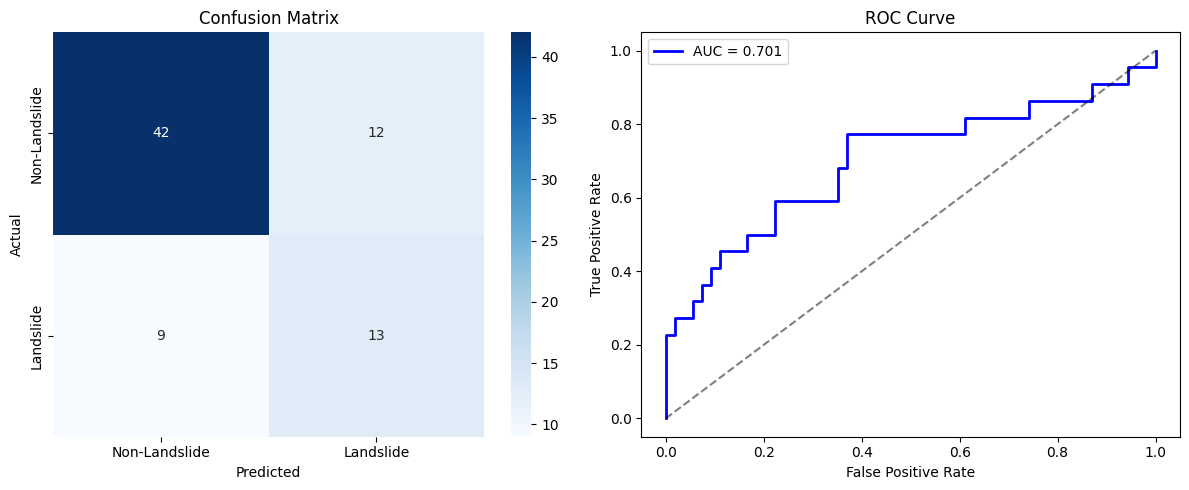

In [11]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Landslide', 'Landslide'],
            yticklabels=['Non-Landslide', 'Landslide'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Feature Importance

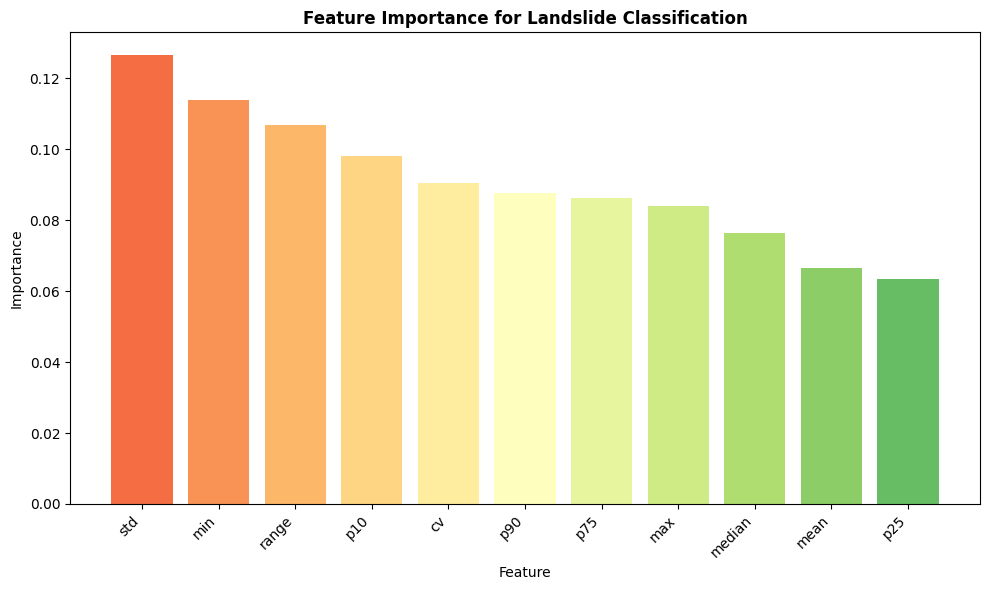


Top Features:
  std: 0.1267
  min: 0.1139
  range: 0.1070
  p10: 0.0980
  cv: 0.0905


In [12]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(importances)))
plt.bar(range(len(importances)), importances[indices], color=colors)
plt.xticks(range(len(importances)), [FEATURE_NAMES[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for Landslide Classification', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop Features:")
for i in indices[:5]:
    print(f"  {FEATURE_NAMES[i]}: {importances[i]:.4f}")

## 7. Save Model and Results

In [13]:
import joblib

# Save model
joblib.dump(rf, 'random_forest_slope_model.joblib')
print("Model saved: random_forest_slope_model.joblib")

# Save feature data
df.to_csv('slope_features_all.csv', index=False)
print("Features saved: slope_features_all.csv")

# Save results summary
results = {
    'accuracy': accuracy_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_proba),
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'n_landslide': int(sum(y)),
    'n_non_landslide': int(len(y) - sum(y)),
    'feature_importance': dict(zip(FEATURE_NAMES, importances.tolist()))
}

import json
with open('model_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print("Results saved: model_results.json")

Model saved: random_forest_slope_model.joblib
Features saved: slope_features_all.csv
Results saved: model_results.json


## Summary

### Dataset
- **377 total samples** (109 landslide + 268 non-landslide)
- **11 slope features** extracted from each 5×5km raster

### Model
- Random Forest with 100 trees, balanced class weights
- 80/20 train/test split with stratification

### Outputs
- `random_forest_slope_model.joblib` - Trained model
- `slope_features_all.csv` - All extracted features
- `model_results.json` - Performance metrics